1. Imports & Global Settings

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"
df = pd.read_csv(file_path, usecols=usecols)

# assign a global match index and derive the round number (10 matches per round)
df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

# extract hour and bucket into time-of-day categories
df['Hour'] = (
    pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')
      .dt.hour
)
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)

# drop the intermediate Hour column
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets: map full-time result to numeric outcome and over-2.5-goals flag
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5'] = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from Bet365 odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread: home vs away
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form for home and away teams
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/loss streaks (number of consecutive wins for home, losses for away)
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction term: how the odds spread interacts with home form
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias: fraction of home wins before this match
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# 3.8 Head-to-head last result between the two teams
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)  # default to 0 if never met
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match statistics (shots, fouls, cards)
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
#   a) assign points per match for home/away
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

#   b) build a long DataFrame of team-round-pts
pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)

#   c) shift positions so that each match sees the previous round’s rank
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# Fill any remaining NaNs in numeric features with zero
num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in home_stats] + [f'Away_{s}_3' for s in away_stats]
df[num_feats] = df[num_feats].fillna(0)

4. Pipeline Specification & Hyperparameter Distributions

In [4]:
from scipy.stats import randint, loguniform

# 4.1 Define feature lists
cat_feats = ['HomeTeam', 'AwayTeam', 'Referee', 'TimeOfDay']

num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in ['HS','HST','HF','HC','HY','HR']] \
  + [f'Away_{s}_3' for s in ['AS','AST','AF','AC','AY','AR']]

# 4.2 Preprocessor: scale numericals, one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats),
], remainder='drop')


# 4.3 Define base learners for stacking
xgb_clf = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
svc_clf = SVC(
    probability=True,
    random_state=42
)
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(100,),
    max_iter=500,
    random_state=42
)

# 4.4 Assemble the StackingClassifier
stack_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb_clf),
        ('svc', svc_clf),
        ('mlp', mlp_clf)
    ],
    final_estimator=LogisticRegression(
        C=1.0,
        max_iter=200,
        random_state=42
    ),
    cv=3,
    n_jobs=-1,
    passthrough=False
)

# 4.5 Model factory
def make_model_stack():
    return Pipeline([
        ('prep', preprocessor),
        ('clf', stack_clf)
    ])


# 4.6 Hyperparameter distributions for RandomizedSearchCV
param_dist = {
    # XGBoost
    'clf__xgb__n_estimators': [100, 200, 500],
    'clf__xgb__max_depth':    [3, 6, 9, None],

    # Support Vector Machine
    'clf__svc__C': loguniform(1e-2, 1e2),

    # Multi-layer Perceptron
    'clf__mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'clf__mlp__alpha':             loguniform(1e-5, 1e-1),

    # Meta-learner (Logistic Regression)
    'clf__final_estimator__C': loguniform(1e-2, 1e2),
}

5. Round-by-Round Training & Prediction with Tuning

In [5]:
preds, actuals, rounds, match_indices = [], [], [], []
warmup = 50   # initial warm‐up for a quick default fit

# 5.1 Warm‐up fit with default stacking pipeline (no tuning)
model = make_model_stack()
model.fit(
    df.loc[:warmup-1, cat_feats + num_feats],
    df.loc[:warmup-1, 'Outcome']
)

# 5.2 Round‐by‐round loop with RandomizedSearchCV
for r in range(6, df['Round'].max() + 1):
    train_idx = df['Round'] < r
    test_idx  = df['Round'] == r

    X_train, y_train = df.loc[train_idx, cat_feats + num_feats], df.loc[train_idx, 'Outcome']
    X_test,  y_test  = df.loc[test_idx,  cat_feats + num_feats], df.loc[test_idx,  'Outcome']

    search = RandomizedSearchCV(
        estimator=make_model_stack(),
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    search.fit(X_train, y_train)
    model = search.best_estimator_

    # make and record predictions
    y_pred = model.predict(X_test)
    preds.extend(y_pred.tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))
    match_indices.extend(df.loc[test_idx, 'MatchIndex'].tolist())

    # optional: per‐round accuracy printout
    acc = accuracy_score(y_test, y_pred)
    print(f"Round {r}: accuracy = {acc:.3f}")

print(f"Predicted rounds 6 to {df['Round'].max()}")

# Save final trained stacking pipeline for downstream use
final_model = model

Round 6: accuracy = 0.500
Round 7: accuracy = 0.500
Round 8: accuracy = 0.500
Round 9: accuracy = 0.800
Round 10: accuracy = 0.500
Round 11: accuracy = 0.500
Round 12: accuracy = 0.600
Round 13: accuracy = 0.300
Round 14: accuracy = 0.500
Round 15: accuracy = 0.800
Round 16: accuracy = 0.600
Round 17: accuracy = 0.700
Round 18: accuracy = 0.400
Round 19: accuracy = 0.700
Round 20: accuracy = 0.600
Round 21: accuracy = 0.500
Round 22: accuracy = 0.600
Round 23: accuracy = 0.700
Round 24: accuracy = 0.800
Round 25: accuracy = 0.600
Round 26: accuracy = 0.600
Round 27: accuracy = 0.700
Round 28: accuracy = 0.600
Round 29: accuracy = 0.500
Round 30: accuracy = 0.400
Round 31: accuracy = 0.600
Round 32: accuracy = 0.400
Round 33: accuracy = 0.600
Round 34: accuracy = 0.600
Round 35: accuracy = 0.700
Round 36: accuracy = 0.800
Round 37: accuracy = 0.800
Round 38: accuracy = 0.900
Predicted rounds 6 to 38


6. Assemble, Save Results & Final Model

In [6]:
# 6.1 Build a DataFrame of predictions aligned with match metadata
df_idx = df.set_index('MatchIndex')
homes  = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways  = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

# Map numeric labels back to H/D/A
label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Save predictions to Excel for later analysis
output_path = r"D:\python\premier league predictor\stacking_predictions_vs_actuals.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

# 6.3 Persist the final stacking pipeline
dump(final_model, r"D:\python\premier league predictor\stacking_pipeline.joblib")
print("Final stacking pipeline saved.")

Results written to D:\python\premier league predictor\stacking_predictions_vs_actuals.xlsx
Final stacking pipeline saved.


7. Results & Visualization

Overall accuracy = 0.603


C:\Users\markf\AppData\Local\Temp\ipykernel_25168\111904402.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['True'], g['Pred']))


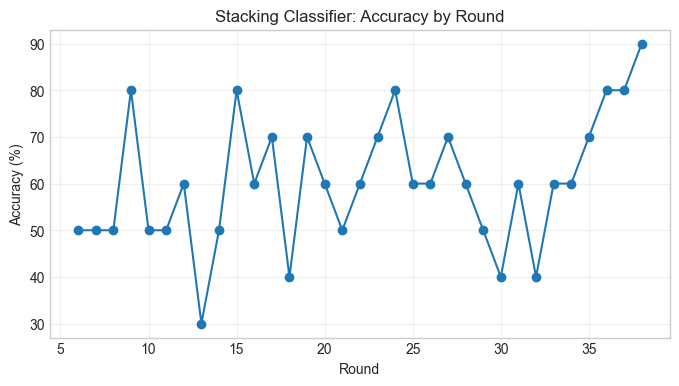

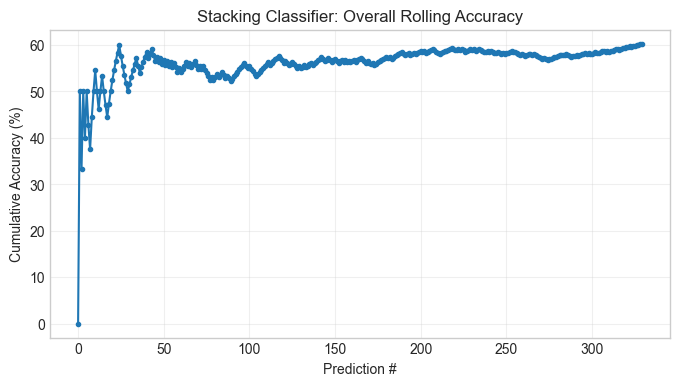

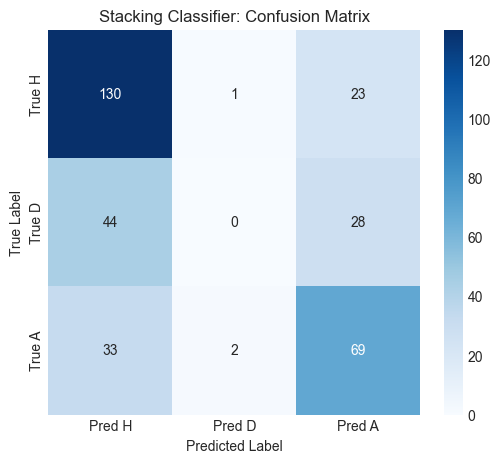

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# 7.0 Overall accuracy (text)
from sklearn.metrics import accuracy_score

if 'predictions_df' in globals() and {'y_true','y_pred'}.issubset(predictions_df.columns) and len(predictions_df) > 0:
    overall_acc = (predictions_df['y_true'] == predictions_df['y_pred']).mean()
elif 'results_df' in globals() and {'Actual','Predicted'}.issubset(results_df.columns) and len(results_df) > 0:
    overall_acc = (results_df['Actual'] == results_df['Predicted']).mean()
elif 'actuals' in globals() and 'preds' in globals() and len(actuals) == len(preds) and len(actuals) > 0:
    overall_acc = accuracy_score(actuals, preds)
else:
    overall_acc = float('nan')

print(f"Overall accuracy = {overall_acc:.3f}")

# Round‐by‐round accuracy
res = pd.DataFrame({'Round': rounds, 'Pred': preds, 'True': actuals})
round_acc = res.groupby('Round') \
               .apply(lambda g: accuracy_score(g['True'], g['Pred']))

plt.figure(figsize=(8,4))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Stacking Classifier: Accuracy by Round')
plt.grid(alpha=0.3)
plt.show()

# Cumulative accuracy over all predictions
cum_acc = np.cumsum(np.array(preds) == np.array(actuals)) / np.arange(1, len(preds) + 1)
plt.figure(figsize=(8,4))
plt.plot(cum_acc * 100, marker='.')
plt.xlabel('Prediction #')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Stacking Classifier: Overall Rolling Accuracy')
plt.grid(alpha=0.3)
plt.show()

# Confusion matrix
cm = confusion_matrix(actuals, preds, labels=[1,0,-1])
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Pred H','Pred D','Pred A'],
    yticklabels=['True H','True D','True A']
)
plt.title('Stacking Classifier: Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


8. Gradio Interface

In [8]:
import gradio as gr

# ----------------------------------------------------------------------------
# 8.1 Precompute training‐set means for odds‐derived features
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# 8.2 Dropdown choices for Gradio
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# 8.3 Prediction function for new fixtures
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # 1) Last known records for home, away, referee
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]

    # 2) Build feature dict
    data = {}
    # 2a) Odds‐derived features → fill with historical averages
    for feat in odd_feats:
        data[feat] = odd_means[feat]

    # 2b) Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']

    # 2c) Interaction term
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']

    # 2d) Referee bias
    data['RefBias'] = ref['RefBias']

    # 2e) Head‐to‐head last
    pair = ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) | \
           ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']

    # 2f) Previous round table positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']

    # 2g) Rolling match stats (shots, fouls, cards)
    home_stats = ['HS','HST','HF','HC','HY','HR']
    away_stats = ['AS','AST','AF','AC','AY','AR']
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']

    # 2h) Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day

    # 3) Create DataFrame, predict probabilities
    Xnew  = pd.DataFrame([data])
    probs = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # e.g. [-1, 0, 1]

    # return percentages for Home Win, Draw, Away Win
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# 8.4 Launch the Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (Stacking)",
    description=(
        "Select Home/Away teams, Referee and Time of Day.\n"
        "Odds‐based features default to their historical averages; "
        "other features pull from the last available match for each entity."
    )
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
